# Setup and Data Loading
Start by importing necessary libraries and loading the data

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
#!pip install adjustText
from adjustText import adjust_text

# Set seed for reproducibility
np.random.seed(1234)

# load the data
# add as header the columns names: statement_id, label, statement, subject, speaker, job_title, state, party, barely_true_c, false_c, half_true_c, mostly_true_c, pants_on_fire_c, context
header = ['statement_id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'party', 'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c', 'pants_on_fire_c', 'context']
test_data = pd.read_csv('./liar_dataset/test.tsv', sep='\t', names=header)
train_data = pd.read_csv('./liar_dataset/train.tsv', sep='\t', names=header)
valid_data = pd.read_csv('./liar_dataset/valid.tsv', sep='\t', names=header)
display(train_data.head())

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [2]:
train_data.info()
test_data.info()
valid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   statement_id     10240 non-null  object 
 1   label            10240 non-null  object 
 2   statement        10240 non-null  object 
 3   subject          10238 non-null  object 
 4   speaker          10238 non-null  object 
 5   job_title        7342 non-null   object 
 6   state            8030 non-null   object 
 7   party            10238 non-null  object 
 8   barely_true_c    10238 non-null  float64
 9   false_c          10238 non-null  float64
 10  half_true_c      10238 non-null  float64
 11  mostly_true_c    10238 non-null  float64
 12  pants_on_fire_c  10238 non-null  float64
 13  context          10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 14 column

clean the data and check for missing values

In [4]:
# show me the NA number for each column
train_data.isnull().sum()


statement_id          0
label                 0
statement             0
subject               2
speaker               2
job_title          2898
state              2210
party                 2
barely_true_c         2
false_c               2
half_true_c           2
mostly_true_c         2
pants_on_fire_c       2
context             102
dtype: int64

In [5]:
valid_data.isnull().sum()

statement_id         0
label                0
statement            0
subject              0
speaker              0
job_title          345
state              279
party                0
barely_true_c        0
false_c              0
half_true_c          0
mostly_true_c        0
pants_on_fire_c      0
context             12
dtype: int64

In [6]:
test_data.isnull().sum()

statement_id         0
label                0
statement            0
subject              0
speaker              0
job_title          325
state              262
party                0
barely_true_c        0
false_c              0
half_true_c          0
mostly_true_c        0
pants_on_fire_c      0
context             17
dtype: int64

In [7]:
# take off the 2 rows that cintain in all the columns NA
# show me the row with the NA in the spkear column
train_data[train_data.speaker.isnull()]
# drop the row with the NA in the spkear column and reset the index
train_data.dropna(subset=['speaker'], inplace=True)
train_data.reset_index(drop=True, inplace=True)
train_data.isnull().sum()

statement_id          0
label                 0
statement             0
subject               0
speaker               0
job_title          2896
state              2208
party                 0
barely_true_c         0
false_c               0
half_true_c           0
mostly_true_c         0
pants_on_fire_c       0
context             100
dtype: int64

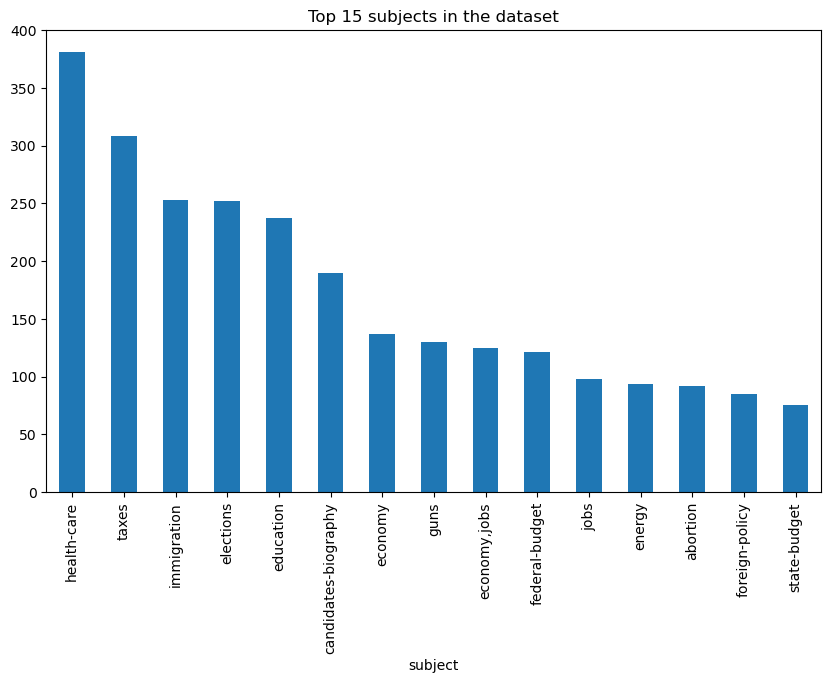

In [8]:
# show the distrubution of the the subject column show the top 15

train_data['subject'].value_counts().head(15).plot(kind='bar', figsize=(10, 6), title='Top 15 subjects in the dataset')
plt.show()

In [10]:
# print the rows with NA values
train_data[train_data['job_title'].isnull()]

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,context
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
6,2342.json,barely-true,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.
8,5602.json,half-true,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,1.0,a website
13,8616.json,mostly-true,The economy bled $24 billion due to the govern...,"economy,federal-budget,health-care",doonesbury,NaN,NaN,none,0.0,0.0,2.0,4.0,0.0,a Doonesbury strip in the Sunday comics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10232,1592.json,half-true,"Under the ruling of the Supreme Court, any lob...","corporations,elections",david-axelrod,NaN,NaN,democrat,2.0,1.0,6.0,7.0,0.0,an interview on ABC's This Week
10233,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report"""
10234,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview
10235,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate


In [11]:
# for thw rows with NA values in the job_title column, print the unique values of the context column
train_data[train_data['job_title'].isnull()]['context'].unique()

array(['a news release', 'an interview on CNN', 'a press release.', ...,
       'a recorded telephone message to Cranston residents',
       'interview on "The Colbert Report"',
       "a televised debate on Miami's WPLG-10 against Kendrick Meek."],
      dtype=object)

# Text Preprocessing
Next, preprocess the text data:

In [12]:
# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Preprocess the text with handling for hyphenated words
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    # Allow hyphenated words by checking if the word is either alphanumeric or contains hyphens
    tokens = [word for word in tokens if all(part.isalnum() for part in word.split('-')) and word not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

def preprocess_dataset(dataset):
    # Apply preprocessing steps on each column
    dataset['processed_text'] = dataset['statement'].apply(preprocess_text)
    dataset['processed_job_title'] = dataset['job_title'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
    dataset['processed_subject'] = dataset['subject'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
    dataset['processed_context'] = dataset['context'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
    return dataset

# Preprocess all datasets
train_data = preprocess_dataset(train_data)
valid_data = preprocess_dataset(valid_data)
test_data = preprocess_dataset(test_data)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sigal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sigal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sigal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Feature Engineering for Text Data

In [61]:
# # Function to average word vectors of column values
# def get_average_word2vec(tokens, model, vector_size):
#     if len(tokens) < 1:
#         return np.zeros(vector_size)
#     vecs = [model.wv[token] for token in tokens if token in model.wv]
#     if len(vecs) == 0:
#         return np.zeros(vector_size)
#     return np.mean(vecs, axis=0)

In [62]:
# statement - will be used to generate new features

In [13]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np

def generate_doc2vec_embeddings(dataset, column_name, vector_size=100, epochs=20):
    """
    Generate Doc2Vec embeddings for a specific column in the dataset.
    
    Parameters:
    dataset (DataFrame): The dataset containing the column to embed.
    column_name (str): The name of the column to embed (e.g., 'processed_subject').
    vector_size (int): The size of the output embedding vector. Default is 100.
    epochs (int): The number of training iterations. Default is 20.
    
    Returns:
    DataFrame: The dataset with an added column containing the Doc2Vec embeddings.
    """
    # Prepare TaggedDocuments for the Doc2Vec model
    documents = [TaggedDocument(words=row, tags=[i]) for i, row in enumerate(dataset[column_name])]
    
    # Train the Doc2Vec model
    doc2vec_model = Doc2Vec(documents, vector_size=vector_size, window=5, min_count=1, workers=4, epochs=epochs)
    
    # Generate and add embeddings to the dataset
    dataset[f'{column_name}_embedding'] = dataset[column_name].apply(lambda x: doc2vec_model.infer_vector(x))
    
    return dataset


In [14]:
# Apply the function to generate embeddings for 'processed_subject' in each dataset
train_data = generate_doc2vec_embeddings(train_data, 'processed_subject')
valid_data = generate_doc2vec_embeddings(valid_data, 'processed_subject')
test_data = generate_doc2vec_embeddings(test_data, 'processed_subject')

# Display the first few rows to verify the results
display(train_data[['processed_subject', 'processed_subject_embedding']].head())
display(valid_data[['processed_subject', 'processed_subject_embedding']].head())
display(test_data[['processed_subject', 'processed_subject_embedding']].head())


,processed_subject,processed_subject_embedding
0,[abortion],"[-0.007209038, 0.04185973, -0.013692677, -0.03..."
1,"[energy, history, job-accomplishments]","[-0.006327158, 0.024077473, -0.011128018, -0.0..."
2,[foreign-policy],"[-0.0063428422, 0.026535962, -0.011454975, -0...."
3,[health-care],"[-0.0033837953, 0.019198133, -0.00058166706, -..."
4,"[economy, job]","[-0.0015934266, 0.018373936, -0.012121808, -0...."


,processed_subject,processed_subject_embedding
0,"[economy, job]","[0.0032948651, -0.0010362199, 0.0004773269, -0..."
1,"[obama-birth-certificate, religion]","[0.008271568, 0.013082046, 0.010249186, -0.023..."
2,"[campaign-finance, congress, tax]","[0.006111837, 0.008518949, 0.0146985585, -0.02..."
3,[poverty],"[0.0010908194, 0.0017067728, 0.00011417172, -0..."
4,"[economy, stimulus]","[0.0055849487, 0.0052138427, 0.0024207155, -0...."


,processed_subject,processed_subject_embedding
0,[immigration],"[0.0051665953, -0.0013142116, -0.0045065447, -..."
1,[job],"[-0.00069963746, -0.0048913658, -9.493806e-05,..."
2,"[military, veteran, voting-record]","[0.0046038134, -0.00021958102, -0.000828231, -..."
3,"[medicare, message-machine-2012, campaign-adve...","[0.004609965, 0.0009205931, -0.0027683135, -0...."
4,"[campaign-finance, legal-issues, campaign-adve...","[0.007799533, 0.00030423, -0.00196414, -0.0148..."


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

def plot_tsne_embeddings(dataset, embedding_column, label_column, subset_size=50, max_label_length=15, title='t-SNE Visualization', random_state=42):
    """
    Plots the t-SNE embeddings for a given dataset with truncated labels.
    
    Parameters:
    dataset (DataFrame): The dataset containing embeddings.
    embedding_column (str): The name of the column with the embeddings.
    label_column (str): The name of the column for text annotations.
    subset_size (int): The number of points to sample and plot for visualization. Default is 50.
    max_label_length (int): Maximum length of the label to display. Default is 15 characters.
    title (str): The title of the plot. Default is 't-SNE Visualization'.
    random_state (int): The random seed for reproducibility. Default is 0.
    
    Returns:
    None. Displays the plot.
    """
    # ignore the NA values
    dataset1 = dataset.dropna(subset=[embedding_column, label_column])
    # Extract the embeddings and labels (text) from the dataset
    embeddings_filtered = np.array(dataset1[embedding_column].tolist())
    labels_filtered = dataset1[label_column].values
    
    # Truncate labels if they exceed max_label_length
    truncated_labels = [label if len(label) <= max_label_length else label[:max_label_length] + '...' for label in labels_filtered]
    
    # Reduce dimensionality to 2D using t-SNE
    tsne = TSNE(n_components=2, random_state=random_state)
    embeddings_2d = tsne.fit_transform(embeddings_filtered)
    
    # Sample a subset of the data for visualization
    indices = np.random.choice(range(len(embeddings_2d)), size=subset_size, replace=False)
    
    # Create a scatter plot of the embeddings
    plt.figure(figsize=(12, 9))
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], c='blue', s=50, alpha=0.6)
    
    # Annotate the points with truncated labels
    texts = []
    for i in indices:
        texts.append(plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], truncated_labels[i], fontsize=10, ha='center', fontweight='bold'))
    
    # Adjust text to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
    
    # Set title and axis labels
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    


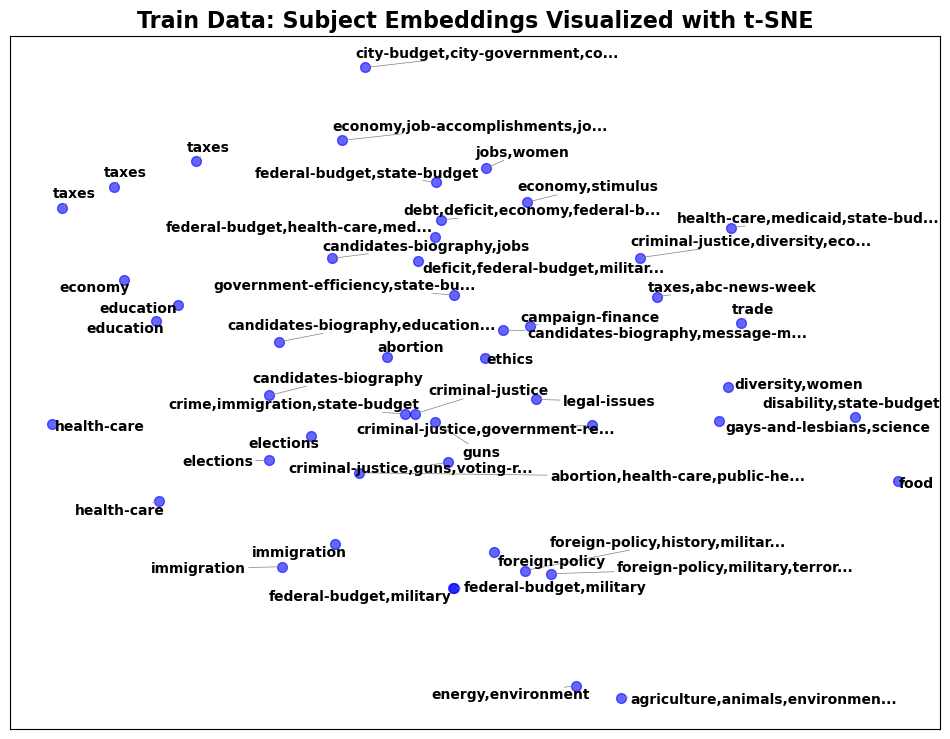

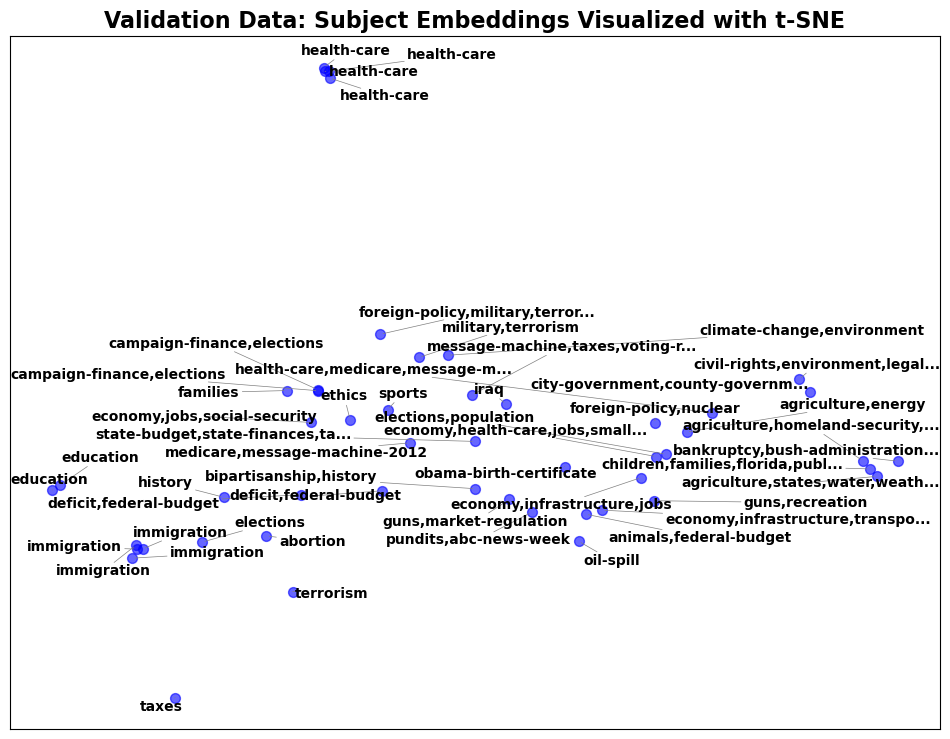

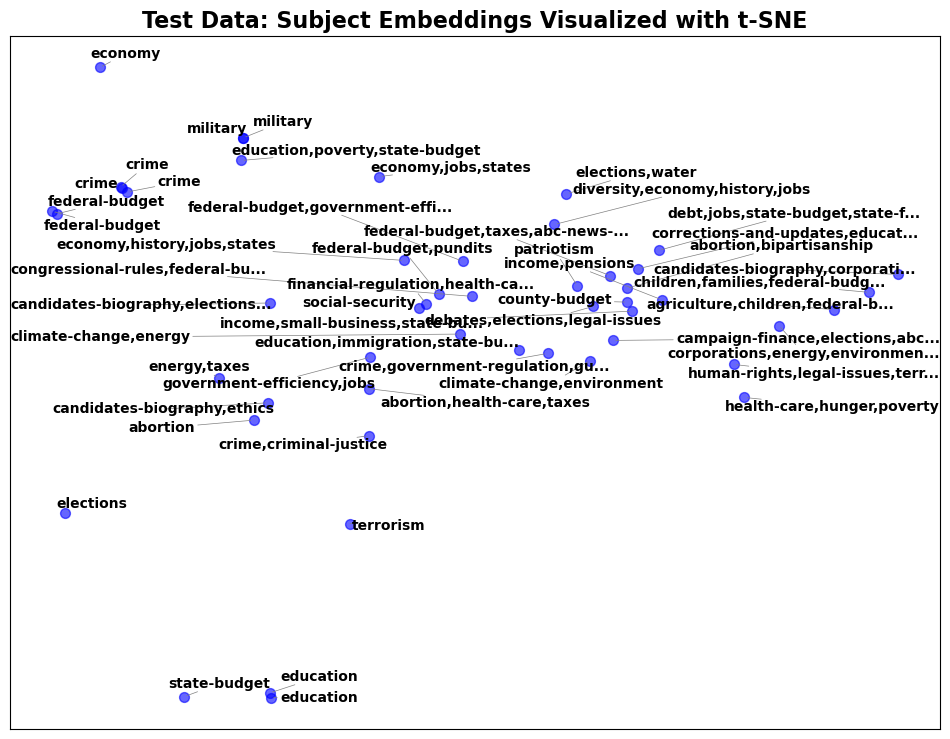

In [16]:
plot_tsne_embeddings(
    dataset=train_data, 
    embedding_column='processed_subject_embedding', 
    label_column='subject', 
    title='Train Data: Subject Embeddings Visualized with t-SNE',
    max_label_length=30  
)

plot_tsne_embeddings(
    dataset=valid_data, 
    embedding_column='processed_subject_embedding', 
    label_column='subject', 
    title='Validation Data: Subject Embeddings Visualized with t-SNE',
    max_label_length=30
)

plot_tsne_embeddings(
    dataset=test_data, 
    embedding_column='processed_subject_embedding', 
    label_column='subject', 
    title='Test Data: Subject Embeddings Visualized with t-SNE',
    max_label_length=30
)




In [67]:
# speaker - dont use it and use counts of the speaker labels

# Feature Engineering: Job Title Embeddings
Use doc2vec to create embeddings for the job titles

In [17]:
# Apply the function to generate Doc2Vec embeddings for 'processed_job_title' in each dataset
train_data = generate_doc2vec_embeddings(train_data, 'processed_job_title')
valid_data = generate_doc2vec_embeddings(valid_data, 'processed_job_title')
test_data = generate_doc2vec_embeddings(test_data, 'processed_job_title')

# Display the first few rows to verify the results
display(train_data[['processed_job_title', 'processed_job_title_embedding']].head())
display(valid_data[['processed_job_title', 'processed_job_title_embedding']].head())
display(test_data[['processed_job_title', 'processed_job_title_embedding']].head())


,processed_job_title,processed_job_title_embedding
0,"[state, representative]","[-0.004011186, 0.003979822, -0.0060168817, 0.0..."
1,"[state, delegate]","[-0.0022348927, 0.022231415, -0.041392807, -0...."
2,[president],"[0.0073284092, -0.0052930657, -0.011248711, -0..."
3,[],"[-0.00428062, -0.0047507333, 0.0028847246, -0...."
4,[],"[0.0026413852, -0.003127886, -0.0007840401, 0...."


,processed_job_title,processed_job_title_embedding
0,[representative],"[-0.0021670028, -0.0006817546, -0.0034780432, ..."
1,[],"[0.00062698545, -0.0045784055, -0.0015896725, ..."
2,[representative],"[-0.002164208, -0.0006712705, -0.0036370892, 0..."
3,"[member, state, board, higher, education]","[-0.02083071, -0.0035321347, 0.011876714, -0.0..."
4,[president],"[0.003506461, -0.0016841604, 0.004495659, 0.00..."


,processed_job_title,processed_job_title_embedding
0,[governor],"[0.0013495823, 0.0045503634, -0.0020606716, 0...."
1,"[state, representative]","[0.0026911327, 0.001795138, 0.00037316876, 7.6..."
2,[president-elect],"[-0.0024257472, -0.0030106446, -0.002531208, -..."
3,[consultant],"[0.0022455978, -0.00018128057, 0.0029403009, -..."
4,[],"[-0.00490747, -0.0040608575, -0.0024175914, 0...."


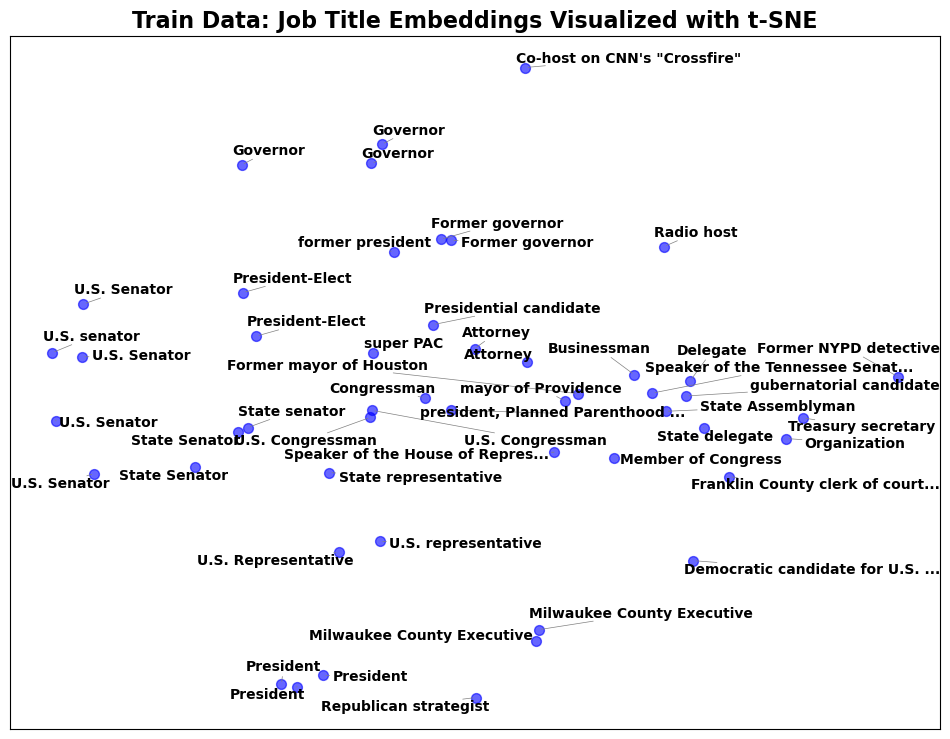

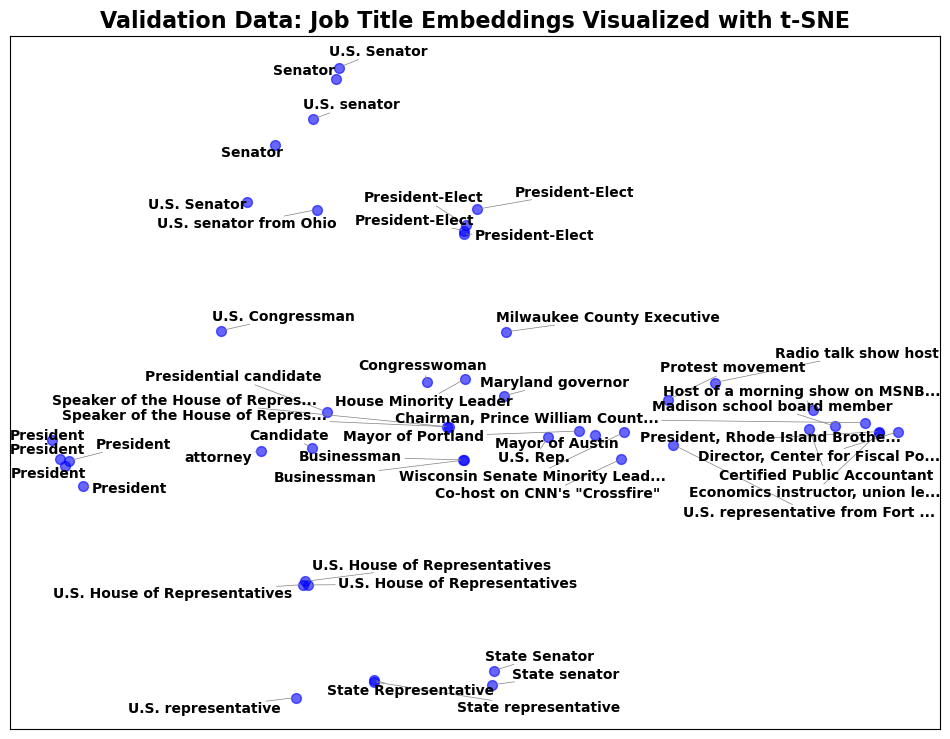

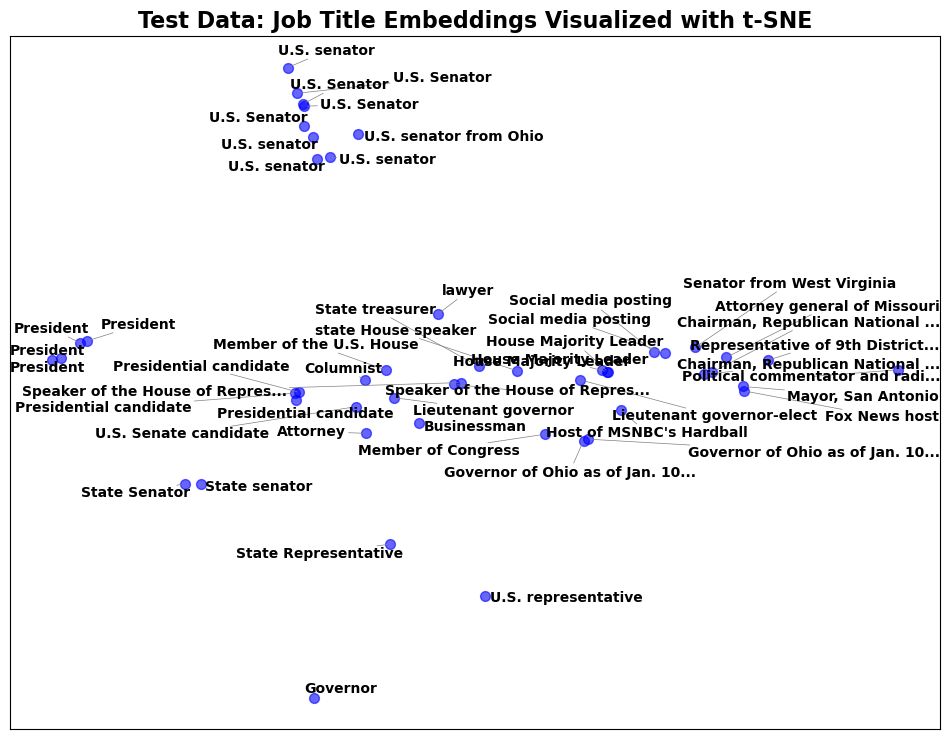

In [18]:
# use function to plot the t-SNE embeddings for the 'processed_job_title' column on train valid and test data
plot_tsne_embeddings(
    dataset=train_data, 
    embedding_column='processed_job_title_embedding', 
    label_column='job_title', 
    title='Train Data: Job Title Embeddings Visualized with t-SNE',
    max_label_length=30  
)

plot_tsne_embeddings(
    dataset=valid_data, 
    embedding_column='processed_job_title_embedding', 
    label_column='job_title', 
    title='Validation Data: Job Title Embeddings Visualized with t-SNE',
    max_label_length=30
)

plot_tsne_embeddings(
    dataset=test_data, 
    embedding_column='processed_job_title_embedding', 
    label_column='job_title', 
    title='Test Data: Job Title Embeddings Visualized with t-SNE',
    max_label_length=30
)

In [19]:
# state - Dont use it for model training.

def state_value_counts(datasets):
    """
    Function to return value counts of the 'state' column for each dataset.
    
    Parameters:
    datasets (dict): A dictionary containing datasets (e.g., {'train': train_data, 'valid': valid_data, 'test': test_data}).
    
    Returns:
    None: Prints the value counts for the 'state' column in each dataset.
    """
    for name, dataset in datasets.items():
        print(f"Value counts for 'state' in {name} dataset:")
        print(dataset['state'].value_counts())
        print("\n")

# Applying the function to the datasets
datasets = {'train': train_data, 'valid': valid_data, 'test': test_data}
state_value_counts(datasets)






Value counts for 'state' in train dataset:
state
Texas             1009
Florida            997
Wisconsin          713
New York           657
Illinois           556
                  ... 
Qatar                1
ohio                 1
Virginia             1
United Kingdom       1
Rhode Island         1
Name: count, Length: 83, dtype: int64


Value counts for 'state' in valid dataset:
state
Texas                   127
Florida                 117
New York                 87
Wisconsin                86
Ohio                     71
Illinois                 68
Georgia                  63
Virginia                 54
Rhode Island             41
New Jersey               34
Oregon                   30
Massachusetts            22
Arizona                  22
Arkansas                 12
Vermont                  12
Kentucky                 11
Washington, D.C.         11
California               11
Minnesota                11
North Carolina           11
New Hampshire            10
Maryland             

# Label Encoding for Party Affiliation
This section encodes the party affiliation of the politicians.

In [20]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Step 1: Create a set of unique 'party' values across train, valid, and test datasets
party_values = set(train_data['party'].unique()).union(set(valid_data['party'].unique())).union(set(test_data['party'].unique()))

# Step 2: Initialize the LabelEncoder and fit it on the combined unique party values
label_encoder = LabelEncoder()
label_encoder.fit(list(party_values))

# Step 3: Apply the same encoder to the 'party' column in each dataset and create a new 'party_encoded' column
train_data['party_encoded'] = label_encoder.transform(train_data['party'])
valid_data['party_encoded'] = label_encoder.transform(valid_data['party'])
test_data['party_encoded'] = label_encoder.transform(test_data['party'])

# Step 4: Display the first few rows of the train dataset to verify the encoding
display(train_data.head())



,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,...,mostly_true_c,pants_on_fire_c,context,processed_text,processed_job_title,processed_subject,processed_context,processed_subject_embedding,processed_job_title_embedding,party_encoded
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,0.0,0.0,a mailer,"[say, annies, list, political, group, support,...","[state, representative]",[abortion],[mailer],"[-0.007209038, 0.04185973, -0.013692677, -0.03...","[-0.004011186, 0.003979822, -0.0060168817, 0.0...",20
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,1.0,0.0,a floor speech.,"[decline, coal, start, started, natural, gas, ...","[state, delegate]","[energy, history, job-accomplishments]","[floor, speech]","[-0.006327158, 0.024077473, -0.011128018, -0.0...","[-0.0022348927, 0.022231415, -0.041392807, -0....",6
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,...,163.0,9.0,Denver,"[hillary, clinton, agrees, john, mccain, votin...",[president],[foreign-policy],[denver],"[-0.0063428422, 0.026535962, -0.011454975, -0....","[0.0073284092, -0.0052930657, -0.011248711, -0...",6
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,...,5.0,44.0,a news release,"[health, care, reform, legislation, likely, ma...",[],[health-care],"[news, release]","[-0.0033837953, 0.019198133, -0.00058166706, -...","[-0.00428062, -0.0047507333, 0.0028847246, -0....",17
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,...,19.0,2.0,an interview on CNN,"[economic, turnaround, started, end, term]",[],"[economy, job]","[interview, cnn]","[-0.0015934266, 0.018373936, -0.012121808, -0....","[0.0026413852, -0.003127886, -0.0007840401, 0....",6


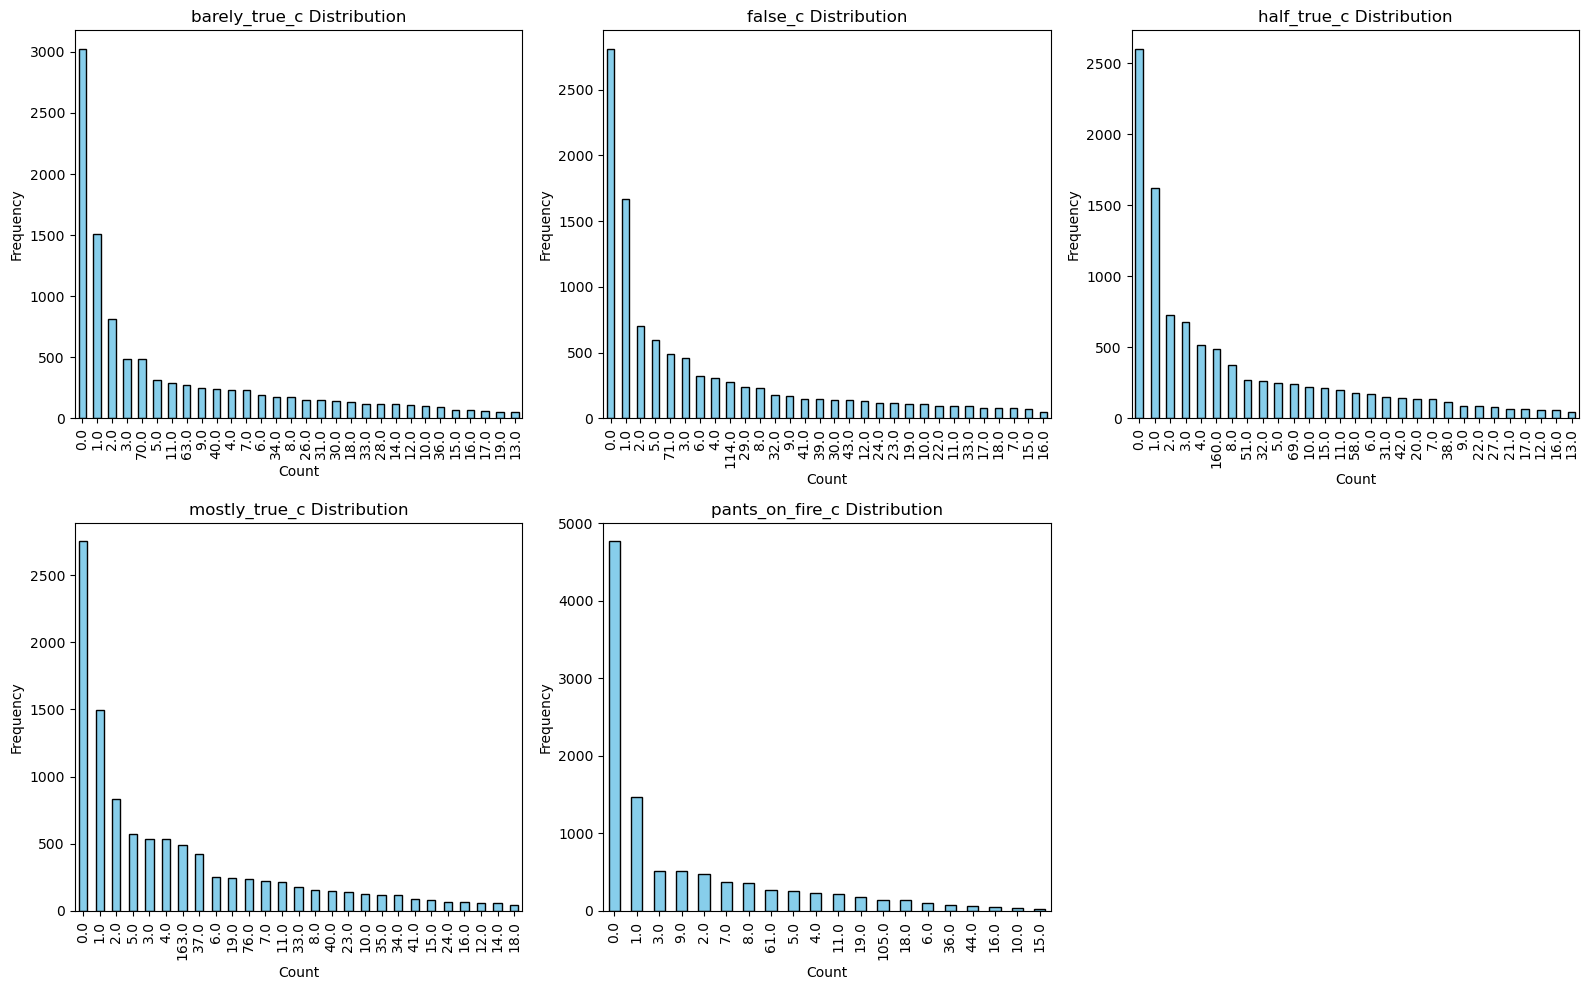

In [21]:
# counts of the speaker labels - use as is
# show the counts distribution of all count columns
count_columns = ['barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c', 'pants_on_fire_c']

def plot_count_distribution(dataset, count_columns):
    
    # Initialize the figure
    plt.figure(figsize=(16, 10))
    
    # Create a stacked bar plot for the count columns
    for i, column in enumerate(count_columns):
        plt.subplot(2, 3, i + 1)
        dataset[column].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title(f'{column} Distribution')
        plt.xlabel('Count')
        plt.ylabel('Frequency')
    
    # Adjust the layout
    plt.tight_layout()
    plt.show()
    
# Plot the count distributions for the train dataset
plot_count_distribution(train_data, count_columns)


In [22]:
# context - docs2vec embedding

# Apply the function to generate embeddings for 'processed_context' in each dataset
train_data = generate_doc2vec_embeddings(train_data, 'processed_context')
valid_data = generate_doc2vec_embeddings(valid_data, 'processed_context')
test_data = generate_doc2vec_embeddings(test_data, 'processed_context')

# Display the first few rows to verify the embeddings
display(train_data[['processed_context', 'processed_context_embedding']].head())
display(valid_data[['processed_context', 'processed_context_embedding']].head())
display(test_data[['processed_context', 'processed_context_embedding']].head())

,processed_context,processed_context_embedding
0,[mailer],"[-0.045663506, 0.00372091, -0.029859083, -0.01..."
1,"[floor, speech]","[-0.047622573, -0.0038553434, -0.011678509, -0..."
2,[denver],"[-0.09164416, -0.012228355, -0.0005609923, -0...."
3,"[news, release]","[-0.017294109, 0.0004485177, 0.012166189, -0.0..."
4,"[interview, cnn]","[-0.024582377, -0.005840717, 0.0054929345, -0...."


,processed_context,processed_context_embedding
0,"[interview, abc17, news]","[-0.0018954668, 0.0023061428, 0.0043932213, -0..."
1,[],"[0.0048149987, -0.0014510846, -0.0033863978, 0..."
2,"[way, mean, hearing]","[-0.009742111, 0.016415263, 0.021117812, -0.02..."
3,"[opinion, article]","[-0.0029760145, 0.013091178, 0.011458247, -0.0..."
4,"[interview, cbs, news]","[0.00012242809, 0.0039331247, 0.009027495, -0...."


,processed_context,processed_context_embedding
0,"[radio, interview]","[-0.0021901499, 0.0073370477, 0.0052444744, -0..."
1,"[news, conference]","[-0.0020047703, 0.006903925, 0.0044528083, -0...."
2,"[comment, abc, week]","[-0.004174717, 0.0024976777, 0.008820245, -0.0..."
3,"[radio, show]","[-0.008176313, 0.0044979304, 0.0031287998, -0...."
4,"[web, video]","[-0.005064224, 0.0025977364, 0.009729136, -0.0..."


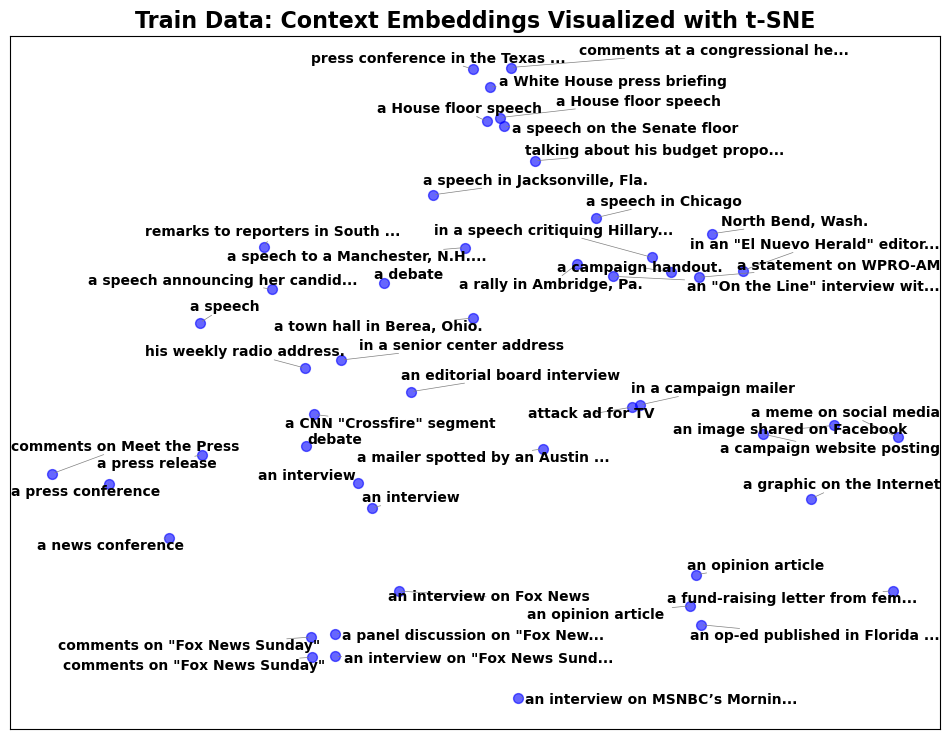

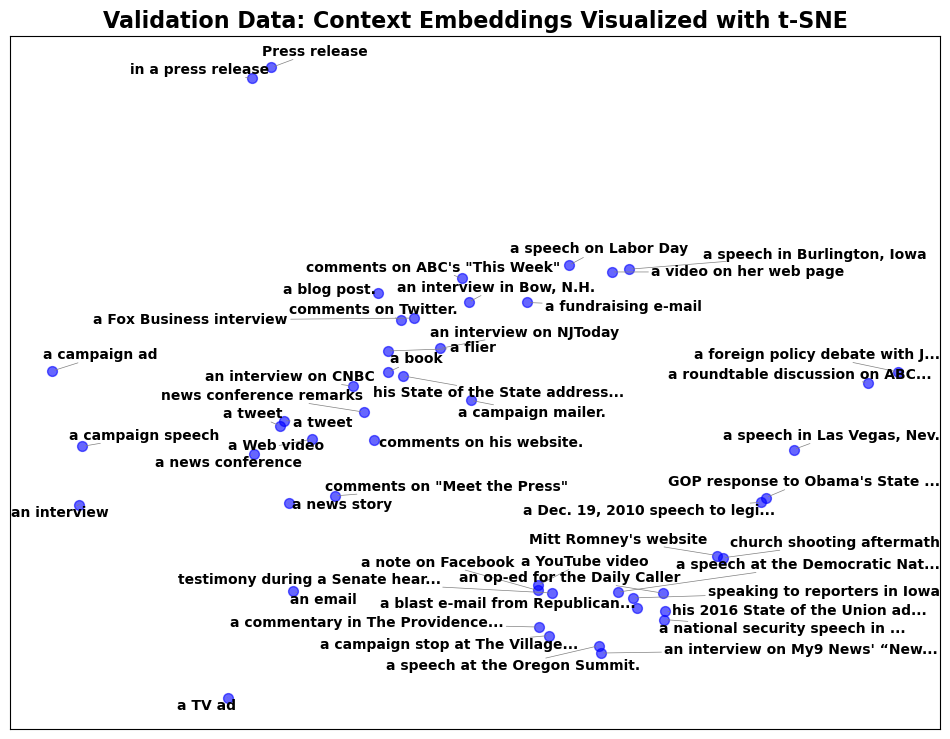

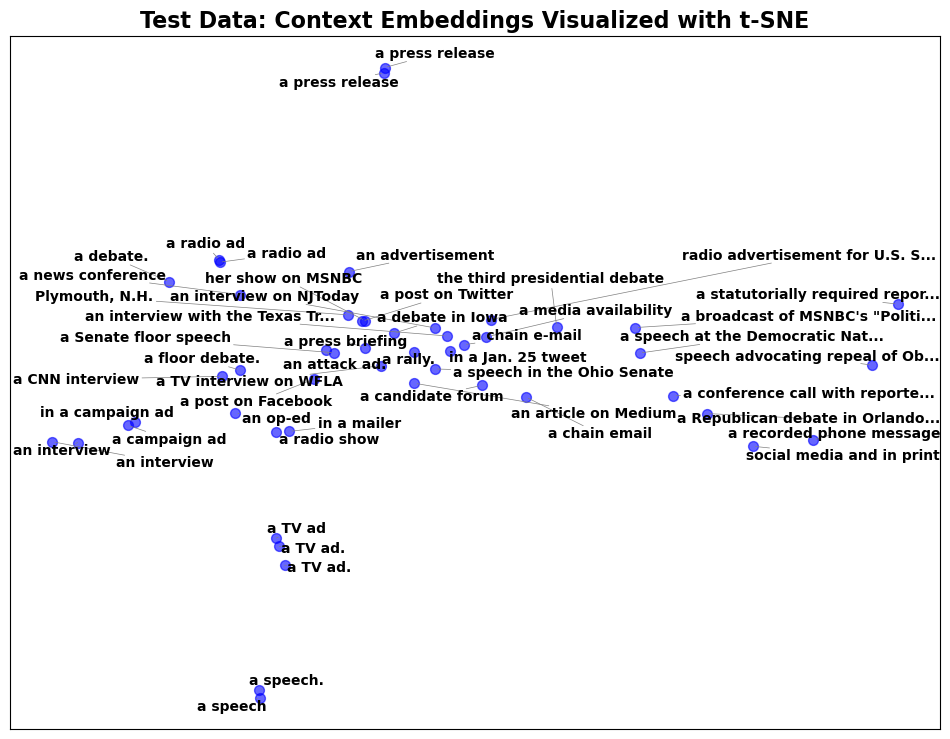

In [23]:
# use function to plot the t-SNE embeddings for the 'processed_context' column on train valid and test data
plot_tsne_embeddings(
    dataset=train_data, 
    embedding_column='processed_context_embedding', 
    label_column='context', 
    title='Train Data: Context Embeddings Visualized with t-SNE',
    max_label_length=30  
)

plot_tsne_embeddings(
    dataset=valid_data, 
    embedding_column='processed_context_embedding', 
    label_column='context', 
    title='Validation Data: Context Embeddings Visualized with t-SNE',
    max_label_length=30
)

plot_tsne_embeddings(
    dataset=test_data, 
    embedding_column='processed_context_embedding', 
    label_column='context', 
    title='Test Data: Context Embeddings Visualized with t-SNE',
    max_label_length=30
)

## Analyzing Correlations Between Embeddings and Label Encodings Using Cosine Similarity and Pearson Correlation

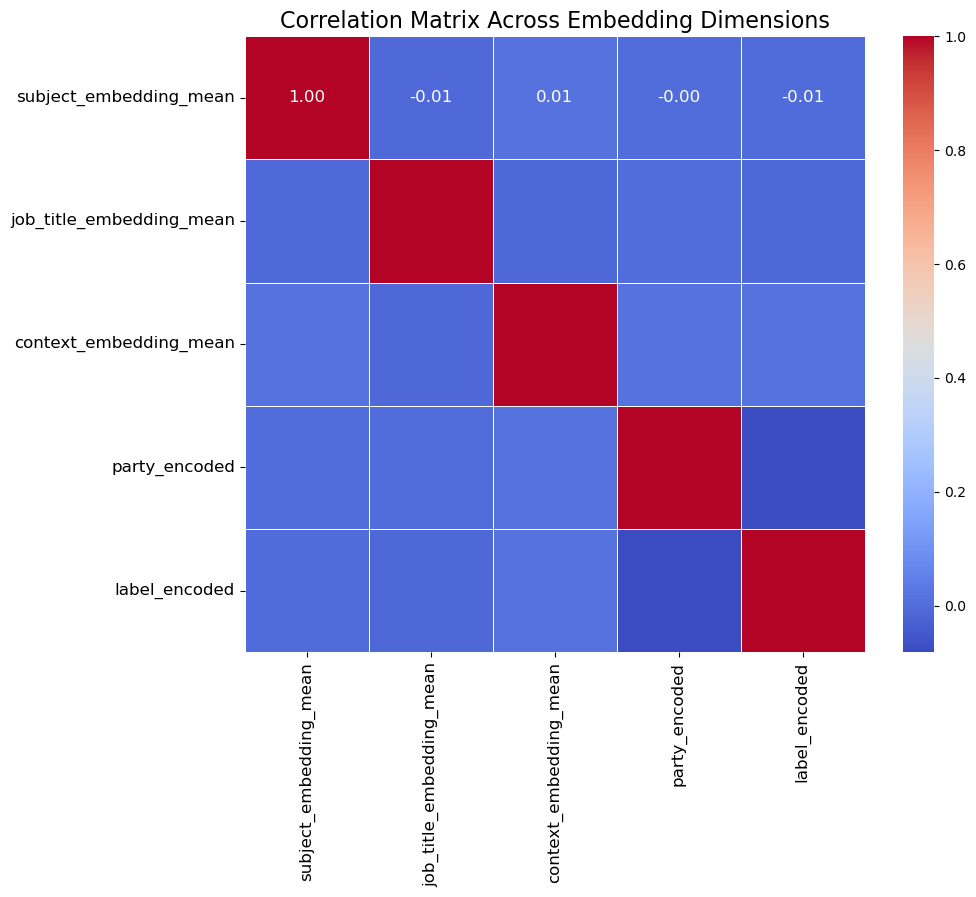

In [24]:
from numpy import dot
from numpy.linalg import norm
from scipy.stats import pearsonr

from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

df = train_data.copy() # Use the train dataset for this analysis

# Fit and transform the 'party' column
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Apply cosine similarity between different embeddings
df['subject_embedding_mean'] = df['processed_subject_embedding'].apply(np.mean)
df['job_title_embedding_mean'] = df['processed_job_title_embedding'].apply(np.mean)
df['context_embedding_mean'] = df['processed_context_embedding'].apply(np.mean)

# Select relevant columns for correlation
part_df = df[['subject_embedding_mean', 'job_title_embedding_mean', 'context_embedding_mean','party_encoded','label_encoded']]
correlation_matrix = part_df.corr()

# Visualize the correlation matrix using a heatmap with numbers on each grid
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Set annot=True to display the correlation values on the heatmap
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt='.2f', annot_kws={"size": 12}, linewidths=0.5, linecolor='white')

plt.title("Correlation Matrix Across Embedding Dimensions", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


Build a basic ML model with the current features and evaluate its performance.

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [26]:
X_train = train_data.select_dtypes(include=['number']).copy()
X_embeddings = np.hstack([
    np.vstack(train_data['processed_subject_embedding'].values),
    np.vstack(train_data['processed_job_title_embedding'].values),
    np.vstack(train_data['processed_context_embedding'].values)
])

X_train_combined = np.hstack([X_train, X_embeddings])
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])

X_valid = valid_data.select_dtypes(include=['number']).copy()
X_embeddings = np.hstack([
    np.vstack(valid_data['processed_subject_embedding'].values),
    np.vstack(valid_data['processed_job_title_embedding'].values),
    np.vstack(valid_data['processed_context_embedding'].values)
])

X_valid_combined = np.hstack([X_valid, X_embeddings])
label_encoder = LabelEncoder()
y_valid = label_encoder.fit_transform(valid_data['label'])


X_test = test_data.select_dtypes(include=['number']).copy()
X_embeddings = np.hstack([
    np.vstack(test_data['processed_subject_embedding'].values),
    np.vstack(test_data['processed_job_title_embedding'].values),
    np.vstack(test_data['processed_context_embedding'].values)
])
X_test_combined = np.hstack([X_test, X_embeddings])
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(test_data['label'])


# Create and fit the RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_combined, y_train)

# Predict using the fitted model
all_predictions = model.predict(X_valid_combined)

# Display the predictions
predicted_labels = label_encoder.inverse_transform(all_predictions)
predicted_labels

array(['half-true', 'false', 'half-true', ..., 'true', 'half-true',
       'mostly-true'], dtype=object)

In [27]:
# 1. Print the shapes of numeric features before embeddings are added
print("Shape of X_train (numeric features):", X_train.shape)
print("Shape of X_valid (numeric features):", X_valid.shape)
print("Shape of X_test (numeric features):", X_test.shape)

# 2. Print the numeric columns for train, valid, and test datasets to check for differences
print("Columns in X_train but not in X_valid:", set(X_train.columns) - set(X_valid.columns))
print("Columns in X_valid but not in X_train:", set(X_valid.columns) - set(X_train.columns))
print("Columns in X_train but not in X_test:", set(X_train.columns) - set(X_test.columns))
print("Columns in X_test but not in X_train:", set(X_test.columns) - set(X_train.columns))


Shape of X_train (numeric features): (10238, 6)
Shape of X_valid (numeric features): (1284, 6)
Shape of X_test (numeric features): (1267, 6)
Columns in X_train but not in X_valid: set()
Columns in X_valid but not in X_train: set()
Columns in X_train but not in X_test: set()
Columns in X_test but not in X_train: set()


In [28]:
from sklearn.metrics import accuracy_score

# Define the parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 15, 20, 25],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [5, 10, 15]
}

# Initialize lists to store results
best_params = None
best_valid_accuracy = 0
results = []

# Loop through all combinations of hyperparameters
for n_estimators in rf_param_grid['n_estimators']:
    for max_depth in rf_param_grid['max_depth']:
        for min_samples_split in rf_param_grid['min_samples_split']:
            for min_samples_leaf in rf_param_grid['min_samples_leaf']:
                
                # Initialize the Random Forest model with current hyperparameters
                rf = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    random_state=42
                )
                
                # Train the model on training data
                rf.fit(X_train_combined, y_train)
                
                # Predict on validation data
                valid_predictions = rf.predict(X_valid_combined)
                
                # Calculate validation accuracy
                valid_accuracy = accuracy_score(y_valid, valid_predictions)
                
                # Store the hyperparameters and accuracy in the results
                results.append({
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'validation_accuracy': valid_accuracy
                })
                
                # Update the best parameters if this is the best accuracy so far
                if valid_accuracy > best_valid_accuracy:
                    best_valid_accuracy = valid_accuracy
                    best_params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf
                    }

# Print the best hyperparameters and their validation accuracy
print("Best Hyperparameters: ", best_params)
print("Best Validation Accuracy: ", best_valid_accuracy)

# Optionally, display all results for further analysis
import pandas as pd
results_df = pd.DataFrame(results)
display(results_df)



KeyboardInterrupt: 

In [30]:
# set the best hyperparameters we found in the previous step
n_estimators = 100
max_depth = 20
min_samples_split = 5
min_samples_leaf = 10


In [31]:
# save the results to a csv file results_df
results_df.to_csv('results_df.csv')
# make plots of the results
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pairplot of the results
sns.pairplot(results_df, diag_kind='kde')
plt.show()


NameError: name 'results_df' is not defined

accuracy 0.39485981308411217
(row=expected, col=predicted)


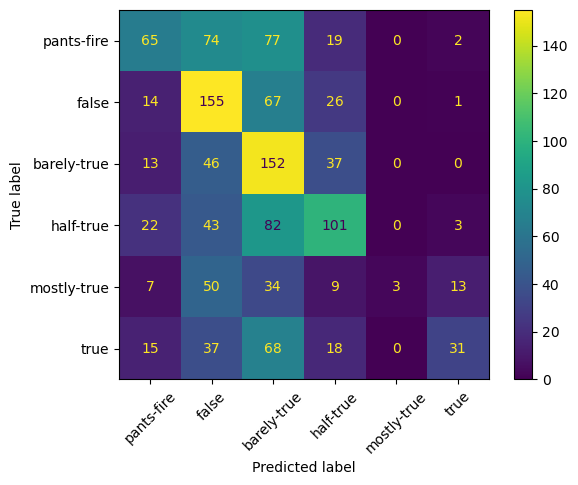

In [32]:
# Create and fit the RandomForestClassifier model with the best hyperparameters
model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
#model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_combined, y_train)

# Predict using the fitted model
all_predictions = model.predict(X_valid_combined)

# Display the predictions
predicted_labels = label_encoder.inverse_transform(all_predictions)
predicted_labels

from sklearn.metrics import accuracy_score , confusion_matrix, ConfusionMatrixDisplay
my_labels =  ['pants-fire','false','barely-true','half-true','mostly-true','true']
print( 'accuracy', accuracy_score(valid_data['label'], predicted_labels))
cm =  confusion_matrix(valid_data['label'], predicted_labels, labels = my_labels)
ConfusionMatrixDisplay.from_predictions(y_true = valid_data['label'], y_pred = predicted_labels , display_labels = my_labels, xticks_rotation = 45)
print('(row=expected, col=predicted)')

accuracy 0.3867403314917127
(row=expected, col=predicted)


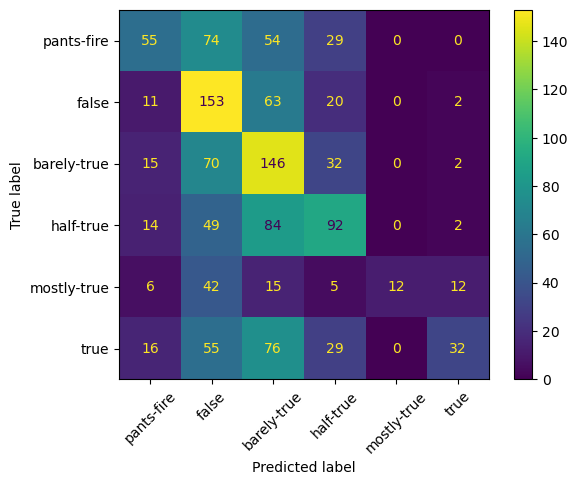

In [33]:
# check the test data on the current model
# Predict using the fitted model
all_predictions = model.predict(X_test_combined)
# Display the predictions
predicted_labels = label_encoder.inverse_transform(all_predictions)
predicted_labels

from sklearn.metrics import accuracy_score , confusion_matrix, ConfusionMatrixDisplay
my_labels =  ['pants-fire','false','barely-true','half-true','mostly-true','true']
print( 'accuracy', accuracy_score(test_data['label'], predicted_labels))
cm =  confusion_matrix(test_data['label'], predicted_labels, labels = my_labels)
ConfusionMatrixDisplay.from_predictions(y_true = test_data['label'], y_pred = predicted_labels , display_labels = my_labels, xticks_rotation = 45)
print('(row=expected, col=predicted)')



# Adding features

## Adding lenght features

In [34]:
# Define the function that applies the transformations
def add_lenght_features(data):
    # Add statement_id as the index
    data['statement_id'] = data.index
    
    # Calculate the length of the statement by words
    data['length_statement_words'] = data['statement'].apply(lambda x: len(x.split()))
    
    # Calculate the length of the statement by letters
    data['length_statement_letters'] = data['statement'].apply(lambda x: len(x.replace(" ", "")))
    
    # Calculate the average word length per statement
    data['avg_word_length_per_statement'] = data['length_statement_letters'] / data['length_statement_words']
    
    # Move the 'statement_id' column to the index
    data = data.set_index('statement_id')
    
    return data

# Apply the function to each dataset
train_data = add_lenght_features(train_data)
valid_data = add_lenght_features(valid_data)
test_data = add_lenght_features(test_data)


## Add credibility score as a feature

In [96]:
import pandas as pd
import numpy as np

# Define penalties for each count column
penalty_weights = {
    'pants_on_fire_c': 40,  # Largest penalty
    'false_c': 30,          # Large penalty
    'barely_true_c': 20,     # Medium penalty
    'half_true_c': 10,       # Small penalty
    'mostly_true_c': 5       # Smallest penalty
}

# Step 1: Calculate the total penalty for each speaker
# Multiply each count column by its corresponding penalty weight
train_data['total_penalty'] = (
    train_data['pants_on_fire_c'] * penalty_weights['pants_on_fire_c'] +
    train_data['false_c'] * penalty_weights['false_c'] +
    train_data['barely_true_c'] * penalty_weights['barely_true_c'] +
    train_data['half_true_c'] * penalty_weights['half_true_c'] +
    train_data['mostly_true_c'] * penalty_weights['mostly_true_c']
)

# Step 2: Calculate the total number of statements (sum of all counts) for each speaker
train_data['total_statements'] = (
    train_data['pants_on_fire_c'] +
    train_data['false_c'] +
    train_data['barely_true_c'] +
    train_data['half_true_c'] +
    train_data['mostly_true_c']
)

# Step 3: Calculate the credibility score
# Start with 100 and subtract the weighted penalty normalized by the total number of statements
train_data['credibility_score'] = 100 - (train_data['total_penalty'] / train_data['total_statements'])
train_data['credibility_score'].fillna(100, inplace=True)  # If no statements, credibility is 100

# Step 4: Repeat the same process for the validation and test datasets
valid_data['total_penalty'] = (
    valid_data['pants_on_fire_c'] * penalty_weights['pants_on_fire_c'] +
    valid_data['false_c'] * penalty_weights['false_c'] +
    valid_data['barely_true_c'] * penalty_weights['barely_true_c'] +
    valid_data['half_true_c'] * penalty_weights['half_true_c'] +
    valid_data['mostly_true_c'] * penalty_weights['mostly_true_c']
)

valid_data['total_statements'] = (
    valid_data['pants_on_fire_c'] +
    valid_data['false_c'] +
    valid_data['barely_true_c'] +
    valid_data['half_true_c'] +
    valid_data['mostly_true_c']
)

valid_data['credibility_score'] = 100 - (valid_data['total_penalty'] / valid_data['total_statements'])
valid_data['credibility_score'].fillna(100, inplace=True)

# For the test data
test_data['total_penalty'] = (
    test_data['pants_on_fire_c'] * penalty_weights['pants_on_fire_c'] +
    test_data['false_c'] * penalty_weights['false_c'] +
    test_data['barely_true_c'] * penalty_weights['barely_true_c'] +
    test_data['half_true_c'] * penalty_weights['half_true_c'] +
    test_data['mostly_true_c'] * penalty_weights['mostly_true_c']
)

test_data['total_statements'] = (
    test_data['pants_on_fire_c'] +
    test_data['false_c'] +
    test_data['barely_true_c'] +
    test_data['half_true_c'] +
    test_data['mostly_true_c']
)

test_data['credibility_score'] = 100 - (test_data['total_penalty'] / test_data['total_statements'])
test_data['credibility_score'].fillna(100, inplace=True)

# Step 5: Verify the new credibility score feature
display(train_data[['speaker', 'credibility_score']].head())
display(valid_data[['speaker', 'credibility_score']].head())
display(test_data[['speaker', 'credibility_score']].head())


,speaker,credibility_score
statement_id,,
0,dwayne-bohac,70.000000
1,scott-surovell,92.500000
2,barack-obama,86.670190
3,blog-posting,67.628205
4,charlie-crist,85.461538


,speaker,credibility_score
statement_id,,
0,vicky-hartzler,85.00000
1,chain-email,66.19186
2,earl-blumenauer,85.00000
3,jim-francesconi,85.00000
4,barack-obama,86.67019


,speaker,credibility_score
statement_id,,
0,rick-perry,80.734266
1,katrina-shankland,76.666667
2,donald-trump,76.027607
3,rob-cornilles,82.142857
4,state-democratic-party-wisconsin,73.043478


In [97]:
# print the speakers with the highest true label counts
train_data[train_data['label'] == 'true']['speaker'].value_counts().head(10)


speaker
barack-obama       103
hillary-clinton     60
mitt-romney         30
john-mccain         29
rick-perry          21
scott-walker        21
chris-christie      18
marco-rubio         16
bernie-s            14
rick-scott          13
Name: count, dtype: int64

In [99]:
# print the speakers with the highest credibility score
train_data[['speaker', 'credibility_score']].sort_values(by='credibility_score', ascending=False).head(10)


,speaker,credibility_score
statement_id,,
9317,john-scocos,100.0
3728,jim-gilmore,100.0
8798,melissa-johnson,100.0
5681,james-skeffington,100.0
8808,john-dennis,100.0
5699,yvette-mcgee-brown,100.0
2886,ryan-lizza,100.0
1870,russell-mcmurry,100.0
2891,ronda-storms,100.0


In [105]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'label' column, and add it to the DataFrame
train_data['label_encoded'] = label_encoder.fit_transform(train_data['label'])




# Calculate the Spearman correlation between the credibility score and label
correlation = train_data['credibility_score'].corr(train_data['label_encoded'], method='spearman')
print(f"Spearman Correlation between credibility score and label_encoded: {correlation}")



Spearman Correlation between credibility score and label_encoded: 0.2427402328188945


c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


## Adding TFIDF feature based on statement text

In [36]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

# Function to fit the model on each dataset and add the 'tfidf' column
def process_data_with_new_model(data, preprocess_text):
    # Step 1: Fit CountVectorizer and TfidfTransformer on the dataset
    bow_transformer = CountVectorizer(analyzer=preprocess_text).fit(data['statement'])
    statements_bow = bow_transformer.transform(data['statement'])
    
    tfidf_transformer = TfidfTransformer().fit(statements_bow)
    statements_tfidf = tfidf_transformer.transform(statements_bow)

    # Step 2: Train the model on the dataset
    model = MultinomialNB().fit(statements_tfidf, data['label'])

    # Step 3: Predict using the trained model
    predictions = model.predict(statements_tfidf)

    # Step 4: Fit the LabelEncoder on the predictions
    label_encoder = LabelEncoder()
    encoded_predictions = label_encoder.fit_transform(predictions)

    # Step 5: Add the encoded predictions as a new column
    data['tfidf'] = encoded_predictions
    
    return data


train_data = process_data_with_new_model(train_data, preprocess_text)

valid_data = process_data_with_new_model(valid_data, preprocess_text)

test_data = process_data_with_new_model(test_data, preprocess_text)

In [38]:
# Display the first few rows of the train dataset to verify the results
display(train_data[['statement', 'tfidf']].head())

# Display the first few rows of the valid dataset to verify the results
display(valid_data[['statement', 'tfidf']].head())

# Display the first few rows of the test dataset to verify the results
display(test_data[['statement', 'tfidf']].head())

,statement,tfidf
statement_id,,
0,Says the Annies List political group supports ...,1
1,When did the decline of coal start? It started...,2
2,"Hillary Clinton agrees with John McCain ""by vo...",2
3,Health care reform legislation is likely to ma...,1
4,The economic turnaround started at the end of ...,2


,statement,tfidf
statement_id,,
0,We have less Americans working now than in the...,3
1,"When Obama was sworn into office, he DID NOT u...",4
2,Says Having organizations parading as being so...,1
3,Says nearly half of Oregons children are poor.,2
4,On attacks by Republicans that various program...,2


,statement,tfidf
statement_id,,
0,Building a wall on the U.S.-Mexico border will...,1
1,Wisconsin is on pace to double the number of l...,1
2,Says John McCain has done nothing to help the ...,1
3,Suzanne Bonamici supports a plan that will cut...,2
4,When asked by a reporter whether hes at the ce...,1


# Topic Modeling with LDA
This section handles topic modeling using LDA (Latent Dirichlet Allocation).

,num_topics,coherence_score
0,4,0.314905
1,6,0.299737
2,8,0.327148
3,10,0.322449
4,12,0.334237
5,14,0.364499
6,16,0.364915
7,18,0.346284
8,20,0.344699


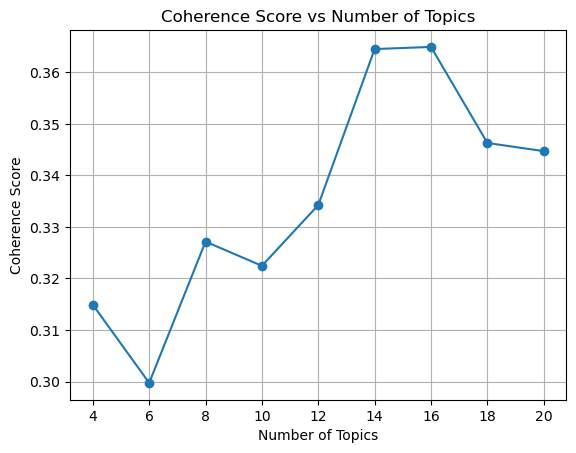

In [87]:
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set seed for reproducibility
np.random.seed(42)

def evaluate_lda_with_coherence(train_data, num_topics_range, passes=20, random_state=42):
    """
    Trains multiple LDA models with different numbers of topics and evaluates them using the coherence score.

    Parameters:
    - train_data: DataFrame containing 'processed_text'
    - num_topics_range: List of numbers of topics to evaluate
    - passes: Number of passes for LDA training (default is 20)
    - random_state: Seed for reproducibility (default is 42)

    Returns:
    - DataFrame containing coherence scores and number of topics
    """
    # Create a dictionary and corpus for the LDA model
    dictionary = corpora.Dictionary(train_data['processed_text'])
    corpus = [dictionary.doc2bow(text) for text in train_data['processed_text']]

    results = []

    for num_topics in num_topics_range:
        # Train the LDA model with a fixed random state
        lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=random_state)

        # Evaluate the model using coherence score
        coherence_model = CoherenceModel(model=lda_model, texts=train_data['processed_text'], dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()

        # Store results
        results.append({'num_topics': num_topics, 'coherence_score': coherence_score})

    # Convert results to DataFrame for easy visualization
    return pd.DataFrame(results)

# Define the range of topics to try
num_topics_range = [4, 6, 8, 10, 12, 14, 16, 18, 20]

# Evaluate LDA models
lda_evaluation_results = evaluate_lda_with_coherence(train_data, num_topics_range)

# Display the coherence scores
display(lda_evaluation_results)

# Plot the coherence scores for easier interpretation
plt.plot(lda_evaluation_results['num_topics'], lda_evaluation_results['coherence_score'], marker='o')
plt.title('Coherence Score vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.show()


In [ ]:
pip install pyLDAvis

In [56]:
# choose the best number of topics 
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def runLDA(data, num_topics = 6, passes=20, random_state=42):
    """
    Trains an LDA model on the given data and returns the trained model.

    Parameters:
    - data: DataFrame containing 'processed_text'
    - num_topics: Number of topics for the LDA model
    - passes: Number of passes for LDA training (default is 20)
    - random_state: Seed for reproducibility (default is 42)

    Returns:
    - Trained LDA model
    """
    # Create a dictionary and corpus for the LDA model
    dictionary = corpora.Dictionary(data['processed_text'])
    corpus = [dictionary.doc2bow(text) for text in data['processed_text']]

    # Train the LDA model with a fixed random state
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=random_state)

    return lda_model, dictionary, corpus

# run the LDA model on the train data, valid data and test data

train_lda_model, train_dict, train_corpus = runLDA(train_data)
valid_lda_model, valid_dict, valid_corpus = runLDA(valid_data)
test_lda_model, test_dict, test_corpus = runLDA(test_data)


In [82]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import webbrowser


# Prepare the visualization
lda_display = gensimvis.prepare(train_lda_model, train_corpus, train_dict)
pyLDAvis.save_html(lda_display, 'train_lda_visualization.html')
webbrowser.open('train_lda_visualization.html')

# Prepare the visualization for the valid data
lda_display = gensimvis.prepare(valid_lda_model, valid_corpus, valid_dict)
pyLDAvis.save_html(lda_display, 'valid_lda_visualization.html')
webbrowser.open('valid_lda_visualization.html')

# Prepare the visualization for the test data
lda_display = gensimvis.prepare(test_lda_model, test_corpus, test_dict)
pyLDAvis.save_html(lda_display, 'test_lda_visualization.html')
webbrowser.open('test_lda_visualization.html')



True

label           barely-true  false  half-true  mostly-true  pants-fire  true
dominant_topic                                                              
0                       218    271        317          303         109   250
1                       403    431        570          477         144   393
2                       194    258        271          285         117   226
3                       263    369        240          251         160   227
4                       275    285        357          393         127   341
5                       301    379        359          253         182   239


<Axes: xlabel='dominant_topic'>

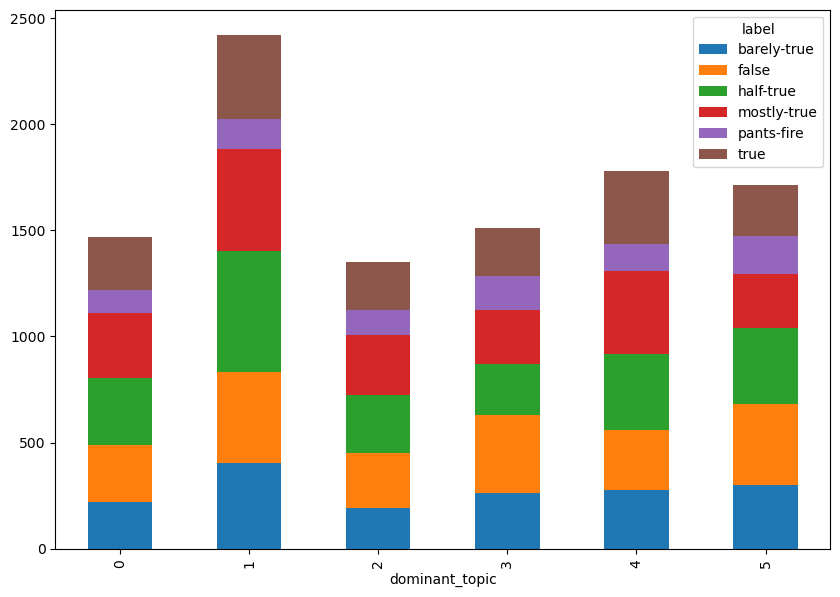

In [57]:

# Get the topic distribution for each document
topic_distributions = train_lda_model.get_document_topics(train_corpus, minimum_probability=0)

# Extract the dominant topic for each document
dominant_topics = []
for dist in topic_distributions:
    # dist is a list of (topic_id, probability) tuples
    dominant_topic = max(dist, key=lambda x: x[1])[0]  # Get the topic with the highest probability
    dominant_topics.append(dominant_topic)

# Add the dominant topic to the DataFrame
train_data['dominant_topic'] = dominant_topics

# Group by topic and label to see the distribution of labels within each topic
label_distribution_by_topic = train_data.groupby(['dominant_topic', 'label']).size().unstack(fill_value=0)

# Display the distribution
print(label_distribution_by_topic)

# Optionally, you can visualize the distribution using a bar chart
label_distribution_by_topic.plot(kind='bar', stacked=True, figsize=(10, 7))

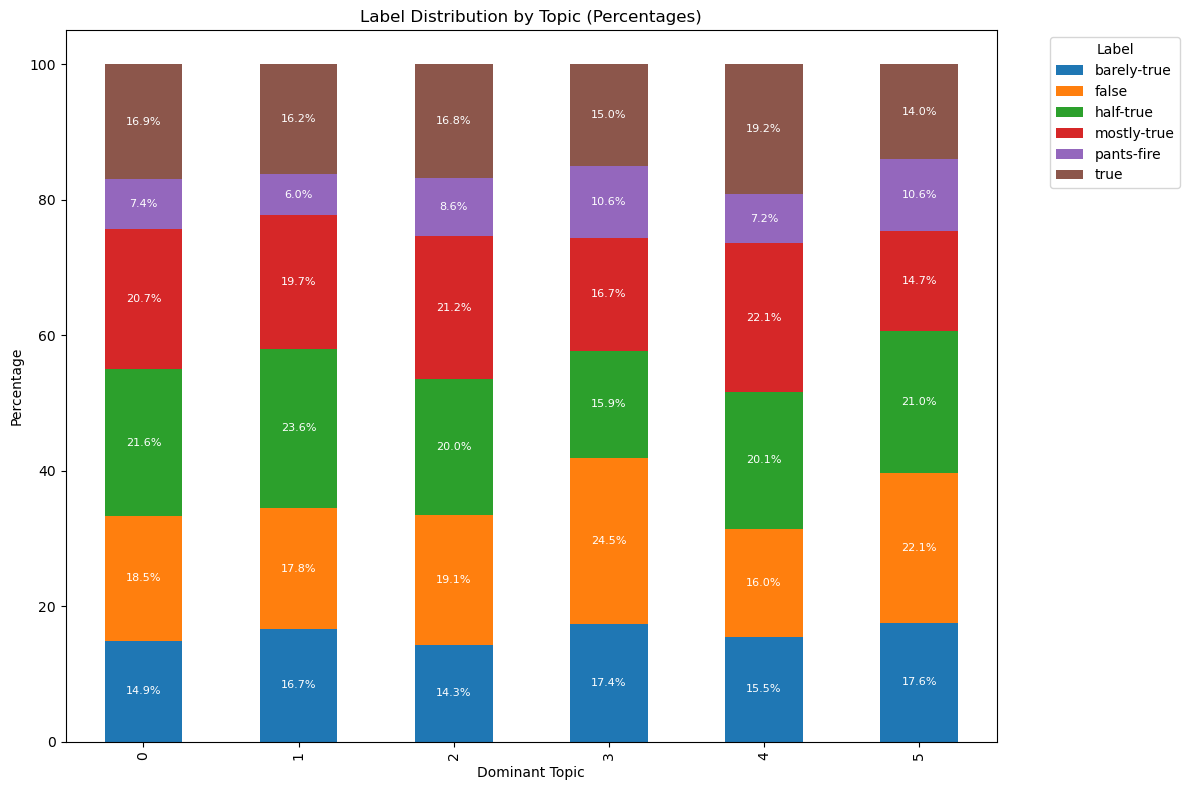

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get the topic distribution for each document
topic_distributions = train_lda_model.get_document_topics(train_corpus, minimum_probability=0)

# Extract the dominant topic for each document
dominant_topics = []
for dist in topic_distributions:
    # dist is a list of (topic_id, probability) tuples
    dominant_topic = max(dist, key=lambda x: x[1])[0]  # Get the topic with the highest probability
    dominant_topics.append(dominant_topic)

# Add the dominant topic to the DataFrame
train_data['dominant_topic'] = dominant_topics

# Group by topic and label to see the distribution of labels within each topic
label_distribution_by_topic = train_data.groupby(['dominant_topic', 'label']).size().unstack(fill_value=0)

# Calculate the percentage distribution within each topic
label_distribution_percentages = label_distribution_by_topic.div(label_distribution_by_topic.sum(axis=1), axis=0) * 100

# Plot the percentage distribution
fig, ax = plt.subplots(figsize=(12, 8))
label_distribution_percentages.plot(kind='bar', stacked=True, ax=ax)

# Add percentages on the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    if height > 0:  # Only label non-zero segments
        ax.text(x + width/2, y + height/2, f'{height:.1f}%', ha='center', va='center', fontsize=8, color='white')

# Move the legend outside the plot
ax.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Label Distribution by Topic (Percentages)')
plt.xlabel('Dominant Topic')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

In [59]:
# add the dominant topic to each sample of the train data
import pandas as pd
import numpy as np

# Define a function to add the dominant topic to the dataset
def add_dominant_topic(lda_model, corpus, data):
    # Get the topic distribution for each document
    topic_distributions = lda_model.get_document_topics(corpus, minimum_probability=0)

    # Extract the dominant topic for each document
    dominant_topics = []
    for dist in topic_distributions:
        dominant_topic = max(dist, key=lambda x: x[1])[0]  # Get the topic with the highest probability
        dominant_topics.append(dominant_topic)

    # Add the dominant topic to the DataFrame
    data['dominant_topic'] = dominant_topics
    
    return data


# Add the dominant topic to each dataset
train_data = add_dominant_topic(train_lda_model, train_corpus, train_data)
valid_data = add_dominant_topic(valid_lda_model, valid_corpus, valid_data)
test_data = add_dominant_topic(test_lda_model, test_corpus, test_data)

# Display the first few rows of each updated DataFrame to verify the result
print(train_data.head())
print(valid_data.head())
print(test_data.head())


                    label                                          statement  \
statement_id                                                                   
0                   false  Says the Annies List political group supports ...   
1               half-true  When did the decline of coal start? It started...   
2             mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3                   false  Health care reform legislation is likely to ma...   
4               half-true  The economic turnaround started at the end of ...   

                                         subject         speaker  \
statement_id                                                       
0                                       abortion    dwayne-bohac   
1             energy,history,job-accomplishments  scott-surovell   
2                                 foreign-policy    barack-obama   
3                                    health-care    blog-posting   
4                              

## Model with new features

In [75]:
# Combine the dominant topic with other numerical features
X_train = train_data.select_dtypes(include=['number']).copy()
X_test = test_data.select_dtypes(include=['number']).copy()

# Since 'dominant_topic' is already numerical, we don't need to embed it.
# Ensure it is included in the training and test sets.
X_train_combined = X_train.values
X_test_combined = X_test.values

# Encode the labels for training
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])
y_test = label_encoder.transform(test_data['label'])


c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

In [80]:
# show me the x_train_combined and x_test_combined shapes
print(X_train)


              barely_true_c  false_c  half_true_c  mostly_true_c  \
statement_id                                                       
0                       0.0      1.0          0.0            0.0   
1                       0.0      0.0          1.0            1.0   
2                      70.0     71.0        160.0          163.0   
3                       7.0     19.0          3.0            5.0   
4                      15.0      9.0         20.0           19.0   
...                     ...      ...          ...            ...   
10233                   0.0      1.0          1.0            1.0   
10234                   0.0      0.0          0.0            1.0   
10235                   4.0     11.0          5.0            3.0   
10236                   3.0      1.0          3.0            0.0   
10237                   0.0      1.0          1.0            0.0   

              pants_on_fire_c  party_encoded  length_statement_words  \
statement_id                               

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
model.fit(X_train_combined, y_train)

# Predict using the trained model
all_predictions = model.predict(X_test_combined)

# Decode the predicted labels
predicted_labels = label_encoder.inverse_transform(all_predictions)

# Calculate the accuracy
accuracy = accuracy_score(test_data['label'], predicted_labels)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.86


c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

In [67]:
# show train and test data 

train_data.head()
test_data.head()

,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,half_true_c,...,processed_context,processed_subject_embedding,processed_job_title_embedding,party_encoded,processed_context_embedding,length_statement_words,length_statement_letters,avg_word_length_per_statement,tfidf,dominant_topic
statement_id,,,,,,,,,,,,,,,,,,,,,
0,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,...,"[radio, interview]","[0.0051665953, -0.0013142116, -0.0045065447, -...","[0.0013495823, 0.0045503634, -0.0020606716, 0....",20,"[-0.0021901499, 0.0073370477, 0.0052444744, -0...",11,58,5.272727,1,3
1,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,...,"[news, conference]","[-0.00069963746, -0.0048913658, -9.493806e-05,...","[0.0026911327, 0.001795138, 0.00037316876, 7.6...",6,"[-0.0020047703, 0.006903925, 0.0044528083, -0....",12,52,4.333333,1,5
2,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,...,"[comment, abc, week]","[0.0046038134, -0.00021958102, -0.000828231, -...","[-0.0024257472, -0.0030106446, -0.002531208, -...",20,"[-0.004174717, 0.0024976777, 0.008820245, -0.0...",10,42,4.200000,1,5
3,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,...,"[radio, show]","[0.004609965, 0.0009205931, -0.0027683135, -0....","[0.0022455978, -0.00018128057, 0.0029403009, -...",20,"[-0.008176313, 0.0044979304, 0.0031287998, -0....",13,73,5.615385,2,4
4,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,...,"[web, video]","[0.007799533, 0.00030423, -0.00196414, -0.0148...","[-0.00490747, -0.0040608575, -0.0024175914, 0....",6,"[-0.005064224, 0.0025977364, 0.009729136, -0.0...",23,105,4.565217,1,5


c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

Accuracy: 0.861878453038674
(row=expected, col=predicted)


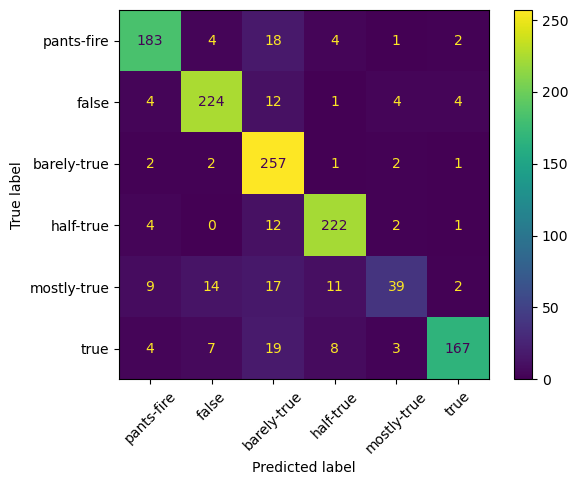

In [69]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Define the labels
my_labels = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']

# Calculate accuracy
accuracy = accuracy_score(test_data['label'], predicted_labels)
print('Accuracy:', accuracy)

# Generate the confusion matrix
cm = confusion_matrix(test_data['label'], predicted_labels, labels=my_labels)

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_true=test_data['label'], 
    y_pred=predicted_labels, 
    display_labels=my_labels, 
    xticks_rotation=45
)

# Print additional information about the confusion matrix
print('(row=expected, col=predicted)')


In [53]:
test_data

,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,half_true_c,...,processed_context,processed_subject_embedding,processed_job_title_embedding,party_encoded,processed_context_embedding,length_statement_words,length_statement_letters,avg_word_length_per_statement,tfidf,dominant_topic
statement_id,,,,,,,,,,,,,,,,,,,,,
0,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,...,"[radio, interview]","[0.0051665953, -0.0013142116, -0.0045065447, -...","[0.0013495823, 0.0045503634, -0.0020606716, 0....",20,"[-0.0021901499, 0.0073370477, 0.0052444744, -0...",11,58,5.272727,1,3
1,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,...,"[news, conference]","[-0.00069963746, -0.0048913658, -9.493806e-05,...","[0.0026911327, 0.001795138, 0.00037316876, 7.6...",6,"[-0.0020047703, 0.006903925, 0.0044528083, -0....",12,52,4.333333,1,5
2,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,...,"[comment, abc, week]","[0.0046038134, -0.00021958102, -0.000828231, -...","[-0.0024257472, -0.0030106446, -0.002531208, -...",20,"[-0.004174717, 0.0024976777, 0.008820245, -0.0...",10,42,4.200000,1,11
3,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,...,"[radio, show]","[0.004609965, 0.0009205931, -0.0027683135, -0....","[0.0022455978, -0.00018128057, 0.0029403009, -...",20,"[-0.008176313, 0.0044979304, 0.0031287998, -0....",13,73,5.615385,2,7
4,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,...,"[web, video]","[0.007799533, 0.00030423, -0.00196414, -0.0148...","[-0.00490747, -0.0040608575, -0.0024175914, 0....",6,"[-0.005064224, 0.0025977364, 0.009729136, -0.0...",23,105,4.565217,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,half-true,Says his budget provides the highest state fun...,education,rick-scott,Governor,Florida,republican,28,23,38,...,"[news, conference]","[0.001606782, 0.002720805, -0.001675477, -0.00...","[0.0014013094, 0.004551055, -0.0020690297, 0.0...",20,"[-0.00092198624, 0.0062194243, 0.003675589, -0...",13,70,5.384615,2,1
1263,barely-true,Ive been here almost every day.,"civil-rights,crime,criminal-justice",jay-nixon,Governor,Missouri,democrat,2,0,0,...,"[abc, week]","[0.00096789375, 0.0056980867, 0.003372703, -0....","[0.0013398054, 0.0045023635, -0.0020431618, 0....",6,"[-0.014297482, 0.013231283, 0.010862101, -0.01...",6,26,4.333333,5,6
1264,barely-true,"In the early 1980s, Sen. Edward Kennedy secret...","bipartisanship,congress,foreign-policy,history",mackubin-thomas-owens,"senior fellow, Foreign Policy Research Institute",Rhode Island,columnist,1,0,0,...,"[commentary, providence, journal]","[0.0011802902, 0.00016459485, -0.004290903, -0...","[0.012257992, 0.005076232, 0.013273406, -0.029...",3,"[-0.021985028, 0.018923441, 0.01632656, -0.019...",21,127,6.047619,0,0


# Feature imporatance analysis

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract the feature importances from the trained model
feature_importances = model.feature_importances_

# Get the feature names from the training dataset (X_train)
feature_names = X_train.columns

# Create a DataFrame to display feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 20 important features
display(feature_importance_df.head(20))


,Feature,Importance
9,tfidf,0.407102
3,mostly_true_c,0.100614
2,half_true_c,0.099749
1,false_c,0.092653
0,barely_true_c,0.090714
4,pants_on_fire_c,0.065499
8,avg_word_length_per_statement,0.041760
7,length_statement_letters,0.039486
6,length_statement_words,0.029457
10,dominant_topic,0.019386


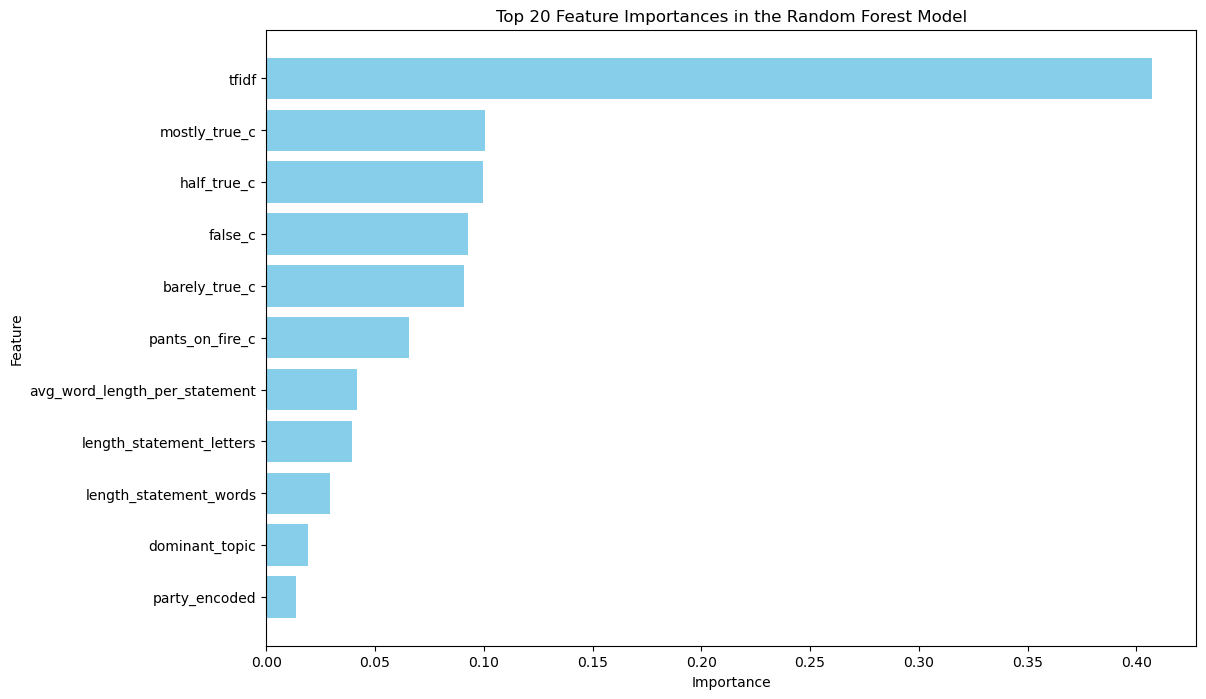

In [71]:
# Plot the top N most important features
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest importance at the top
plt.title('Top 20 Feature Importances in the Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
